In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/for_classification.csv', index_col = 0)

In [ ]:
import re

df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

,Temp,Timeh,ConcuM,target,tsne_x,tsne_y,group
0,23.0,0.250000,12.5,650.00,-40.219130,14.996376,1
1,23.0,0.166667,12.5,31.25,-11.696666,-12.144397,1
2,23.0,0.166667,12.5,10.00,-14.078933,-16.412716,1
3,23.0,0.166667,12.5,22.50,-12.919512,-15.242726,1
4,23.0,0.166667,12.5,20.00,-13.078206,-15.539741,1
...,...,...,...,...,...,...,...
1731,37.0,4.000000,10.0,800.00,-40.510406,9.274917,1
1732,37.0,4.000000,10.0,2000.00,30.364430,-21.708519,2
1733,37.0,24.000000,50000.0,10.00,21.282910,17.018114,2
1734,37.0,24.000000,50000.0,50.00,21.285471,17.022339,2


In [ ]:
X = df.drop(['group', 'target', 'tsne_x', 'tsne_y'], axis = 1)
y = df[['group']]

In [ ]:
# @title scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
def data_prep(X, y):
  X_scaled = X.copy()
  scalers = {}  # Словарь для хранения scaler'ов для каждого столбца

  for column in X.columns:
    scaler = MinMaxScaler()
    X_scaled[column] = scaler.fit_transform(X[[column]])
    scalers[column] = scaler


  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



  return X_train, X_test, y_train, y_test

In [ ]:
# @title LGB
import lightgbm as lgb
import lightgbm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
def LGB(X_train, y_train, X_test, y_test):

    clf = lgb.LGBMClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

    y_pred_train = clf.predict(X_train)

    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy))
    print('Cross-validation accuracy scores: {0}'.format(scores))
    print('Cross-validation accuracy: {0}'.format(np.mean(scores)))

    train_accuracy = accuracy_score(y_train, y_pred_train)

    print('nTrain Accuracy:{0:0.4f}'.format(train_accuracy))

    print(classification_report(y_test, y_pred))


    lightgbm.plot_importance(clf, max_num_features = 60, height=.9)
    plt.show()


    feature_importance = clf.feature_importances_

# Нормализация значений feature importance
    normalized_importance = feature_importance / np.sum(feature_importance)
    sorted_indices = np.argsort(normalized_importance)[::-1]  # Сортировка в порядке убывания

# Ограничение количества значений для отображения (например, первые 10 значений)
    top_n = 25
    sorted_indices = sorted_indices[:top_n]

# Сортировка значений и признаков
    sorted_importance = normalized_importance[sorted_indices]
    sorted_features = X_train.columns[sorted_indices]

# Построение графика с отсортированными и ограниченными значениями feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x=sorted_importance, y=sorted_features)
    plt.xlabel('Normalized Importance')
    plt.ylabel('Features')
    plt.title('Top {} Feature Importance'.format(top_n))
    plt.show()
    print(feature_importance)

In [ ]:
# @title XGB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

def XGB(X_train, y_train, X_test, y_test):
    # XGBoost model
    xgb = XGBClassifier()
    y_train.replace({7:0}, inplace=True)
    y_test.replace({7:0}, inplace=True)
    # Cross-validation
    cv_scores = cross_val_score(xgb, X_train, y_train, cv=5)
    print("Cross-validation scores:", cv_scores.mean())

    # Fit and predict
    xgb.fit(X_train, y_train)
    accuracy = xgb.score(X_test, y_test)
    print("Accuracy on test set for XGBoost: {:.2f}".format(accuracy))

    # Classification report
    y_pred = xgb.predict(X_test)
    y_pred_train = xgb.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print("nTrain Accuracy:{0:0.4f}".format(train_accuracy))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [ ]:
# @title RF
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
def RF(X_train, y_train, X_test, y_test):
  rfc = RandomForestClassifier()
  y_train.replace({0:7}, inplace=True)
  y_test.replace({0:7}, inplace=True)
  rfc.fit(X_train, y_train)

  y_pred = rfc.predict(X_test)

  cv_scores = cross_val_score(rfc, X_train, y_train, cv=5)
  print("Cross-validation scores:", cv_scores.mean())

  y_pred_train = rfc.predict(X_train)
  train_accuracy = accuracy_score(y_train, y_pred_train)
  print("Train accuracy:", train_accuracy)

  print("Classification Report:")
  print(classification_report(y_test, y_pred))
  print()
  print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
# @title SVM
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
def SVM(X_train, y_train, X_test, y_test):
  svc=SVC(C=1000.0)


# fit classifier to training set
  svc.fit(X_train,y_train)


# make predictions on test set
  y_pred=svc.predict(X_test)
  cv_scores = cross_val_score(svc, X_train, y_train, cv=5)
  print("Cross-validation scores:", cv_scores.mean())

  print("Classification Report:")
  print(classification_report(y_test, y_pred))

# compute and print accuracy score
  print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
def evaluate(X, y):
    X_train_scaled, X_test_scaled, y_train, y_test = data_prep(X,y)
    print('LGBM')
    LGB(X_train_scaled, y_train, X_test_scaled, y_test)
    print('XGB')
    XGB(X_train_scaled, y_train, X_test_scaled, y_test)
    print('RF')
    RF(X_train_scaled, y_train, X_test_scaled, y_test)
    print('SVM')
    SVM(X_train_scaled, y_train, X_test_scaled, y_test)

LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 1388, number of used features: 3
[LightGBM] [Info] Start training from score -2.610646
[LightGBM] [Info] Start training from score -0.505795
[LightGBM] [Info] Start training from score -1.128596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 1110, number of used features: 3
[LightGBM] [Info] Start training from score -2.605396
[LightGBM] [Info] Start training from score -0.506331
[LightGBM] [Info] Start training from score -1.128793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1110, number of used features: 3
[LightGBM] [Info] Start training from score -2.617666
[LightGBM] [Info] Start training from score -0.506331
[LightGBM] [Info] Start training from score -1.126011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 1110, number of used features: 3
[LightGBM] [Info] Start training from score -2.617666
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Info] Start training from score -1.128793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 1111, number of used features: 3
[LightGBM] [Info] Start training from score -2.606297
[LightGBM] [Info] Start training from score -0.505738
[LightGBM] [Info] Start training from score -1.129693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1111, number of used features: 3
[LightGBM] [Info] Start training from score -2.606297
[LightGBM] [Info] Start training from score -0.505738
[LightGBM] [Info] Start training from score -1.129693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

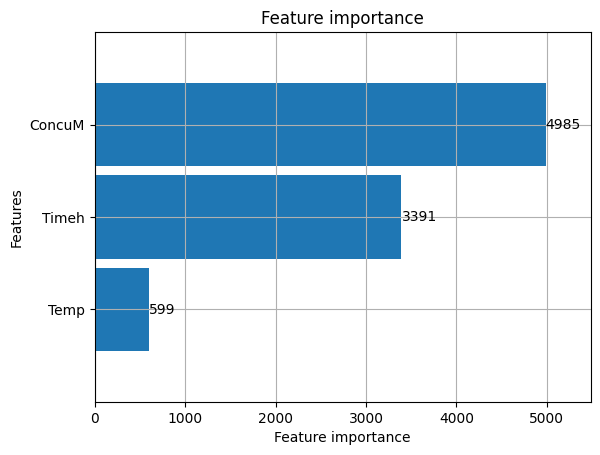

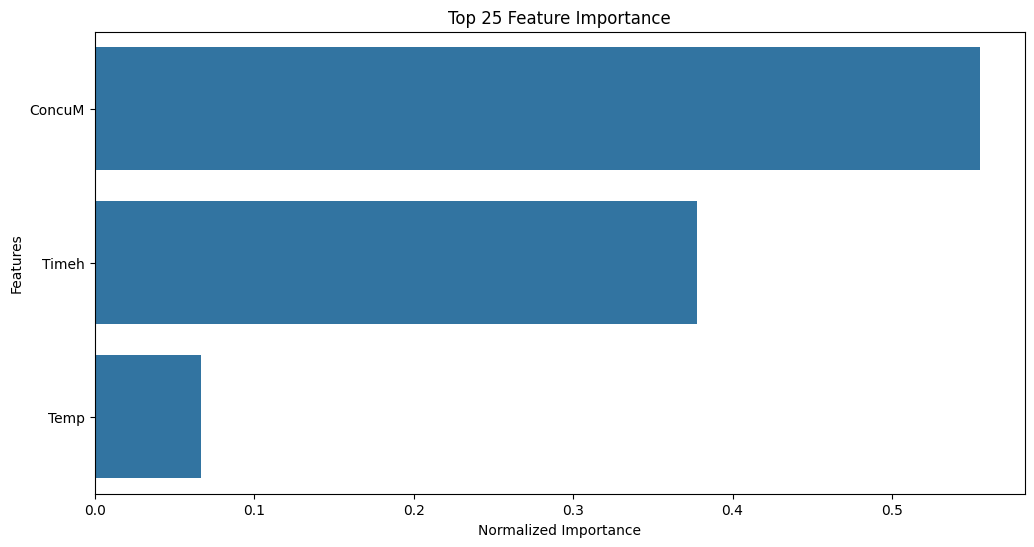

[ 599 3391 4985]
XGB
Cross-validation scores: 0.8486975040905904
Accuracy on test set for XGBoost: 0.85
nTrain Accuracy:0.9071
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       0.86      0.92      0.89       220
           2       0.81      0.67      0.74       104

    accuracy                           0.85       348
   macro avg       0.86      0.86      0.86       348
weighted avg       0.85      0.85      0.85       348

RF


<ipython-input-84-59e5e28b5c72>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

Cross-validation scores: 0.8414876762849648
Train accuracy: 0.9106628242074928
Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.92      0.89       220
           2       0.82      0.68      0.74       104
           7       0.89      1.00      0.94        24

    accuracy                           0.85       348
   macro avg       0.86      0.87      0.86       348
weighted avg       0.85      0.85      0.85       348


Model accuracy score with 10 decision-trees : 0.8534
SVM


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Cross-validation scores: 0.7802482923408566
Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.97      0.86       220
           2       0.86      0.47      0.61       104
           7       0.94      0.62      0.75        24

    accuracy                           0.80       348
   macro avg       0.86      0.69      0.74       348
weighted avg       0.81      0.80      0.78       348

Model accuracy score with default hyperparameters: 0.7989


In [ ]:
evaluate(X,y)